In [1]:
%load_ext autoreload
%autoreload 2
import waffles
import numpy as np
import json
import shutil 
from tqdm import tqdm
from waffles.input_output.hdf5_structured import load_structured_waveformset
from waffles.data_classes.Waveform import Waveform
from waffles.data_classes.WaveformSet import WaveformSet
from waffles.data_classes.BasicWfAna import BasicWfAna
from waffles.data_classes.IPDict import IPDict
from waffles.data_classes.UniqueChannel import UniqueChannel
from waffles.data_classes.ChannelWsGrid import ChannelWsGrid
from waffles.utils.baseline.baseline import SBaseline
from waffles.np02_utils.AutoMap import generate_ChannelMap, dict_uniqch_to_module, dict_module_to_uniqch
from waffles.np02_utils.PlotUtils import np02_gen_grids, plot_grid, plot_detectors, genhist, fithist, runBasicWfAnaNP02

In [2]:
dettype = "membrane"
## Only change if necessary
datadir = f"/eos/experiment/neutplatform/protodune/experiments/ProtoDUNE-VD/commissioning/"
det = "VD_Cathode_PDS" if dettype == "cathode" else "VD_Membrane_PDS"
endpoint = 106 if dettype == "cathode" else 107

# Way to low... keep scrollng
dletter = dettype.upper()[0] # C or M...
group1 = [ f"{dletter}{detnum}({chnum})" for detnum in range(1, 3) for chnum in range(1,3) ]
group2 = [ f"{dletter}{detnum}({chnum})" for detnum in range(3, 5) for chnum in range(1,3) ]
group3 = [ f"{dletter}{detnum}({chnum})" for detnum in range(5, 7) for chnum in range(1,3) ]
group4 = [ f"{dletter}{detnum}({chnum})" for detnum in range(7, 9) for chnum in range(1,3) ]
groupall = group1+group2+group3+group4

In [3]:
from glob import glob
import copy
def open_processed(run, dettype, output_dir, nwaveforms=None, mergefiles = False, verbose=True):
    """
    Open the processed waveform set for a given run and detector type.
    """
    endpoint = None
    channels = None
    try: 
        wfset = load_structured_waveformset(f"{output_dir}/processed/run{run:0d}_{dettype}/processed_merged_run{run:06d}_structured_{dettype}.hdf5", max_waveforms=nwaveforms)
    except:
        files = glob(f"{output_dir}/processed/run{run:06d}_{dettype}/processed_*_run{run:06d}_*_{dettype}.hdf5")
        if verbose:
            print("List of files found:")
            print(files)
        if not mergefiles or len(files)==1:
            files = files[0]
            wfset = load_structured_waveformset(files, endpoint_filter=endpoint, channels_filter=channels, max_waveforms=nwaveforms, verbose=verbose)
        else: 
            wfset = load_structured_waveformset(files[0], endpoint_filter=endpoint, channels_filter=channels, max_waveforms=nwaveforms, verbose=verbose)
            for f in files[1:]:
                wfset = load_structured_waveformset(files, endpoint, channels, max_waveforms=nwaveforms, verbose=verbose)
                tmpwf = load_structured_waveformset(f, max_waveforms=nwaveforms, verbose=verbose)
                wfset.merge(copy.deepcopy(tmpwf))
    return wfset

In [74]:
#Offset scan membranes
runlist = [39117, 39118, 39119, 39120, 39121, 39122, 39123, 39124, 39125, 39126, 39127, 39128, 39129, 39130, 39131]
offsets = [2000, 2050, 2100, 2150, 2200, 2250, 2300, 2350, 2400, 2450, 2500, 2550, 2600, 2650, 2700]

runlist = [39124, 39125, 39126, 39127, 39128, 39129, 39130, 39131]
offsets = [2350, 2400, 2450, 2500, 2550, 2600, 2650, 2700]

runlist, offset = zip(*sorted(zip(runlist, offsets), key=lambda x: x[1], reverse=True))

waveforms = {}
def process_runs(runlist):
    histograms_ch = {}
    bins = np.linspace(0, 8000, 1000)
    for run in runlist:
        wfset = open_processed(run, dettype, datadir, nwaveforms=4000, verbose=True)
        wfch = ChannelWsGrid.clusterize_waveform_set(wfset)
        waveforms[run] = wfset
        for ep, val in wfch.items():
            for ch, wfs in val.items():
                #if ch != 2:
                #    continue
                values = [wf.adcs[:200] for wf in wfs.waveforms]
                #values = [np.sqrt(np.sum((wf.adcs[:200] - np.mean(wf.adcs[:200]))**2)) for wf in wfs.waveforms]

                counts, bins = np.histogram(bins=bins, a=values)
        
                if ch not in histograms_ch:
                    histograms_ch[ch] = {run: counts}
                else:
                    histograms_ch[ch][run] = counts

    return histograms_ch, bins

histograms_ch, bins = process_runs(runlist)

List of files found:
['/eos/experiment/neutplatform/protodune/experiments/ProtoDUNE-VD/commissioning//processed/run039131_membrane/processed_np02vd_raw_run039131_0000_df-s04-d0_dw_0_20250826T174111.hdf5.copied_structured_membrane.hdf5']
📤 load_structured_waveformset returning type: <class 'waffles.data_classes.WaveformSet.WaveformSet'> with 4000 waveforms
List of files found:
['/eos/experiment/neutplatform/protodune/experiments/ProtoDUNE-VD/commissioning//processed/run039130_membrane/processed_np02vd_raw_run039130_0000_df-s04-d0_dw_0_20250826T173806.hdf5.copied_structured_membrane.hdf5']
📤 load_structured_waveformset returning type: <class 'waffles.data_classes.WaveformSet.WaveformSet'> with 4000 waveforms
List of files found:
['/eos/experiment/neutplatform/protodune/experiments/ProtoDUNE-VD/commissioning//processed/run039129_membrane/processed_np02vd_raw_run039129_0000_df-s04-d0_dw_0_20250826T173500.hdf5.copied_structured_membrane.hdf5']
📤 load_structured_waveformset returning type: <

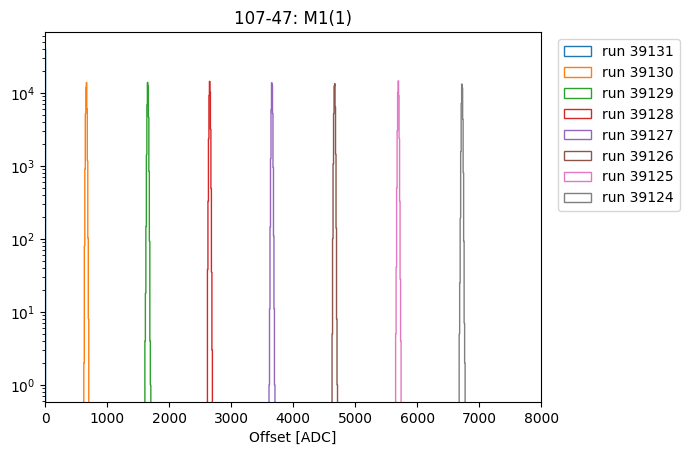

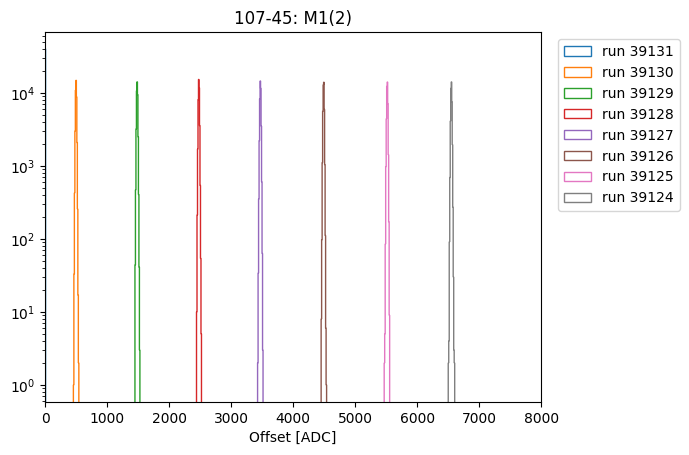

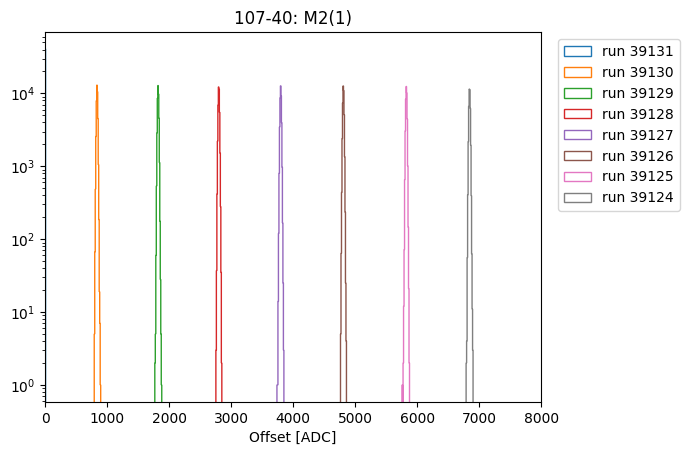

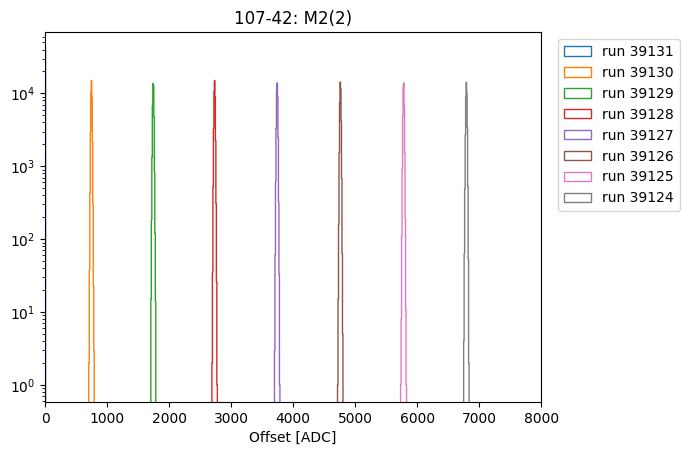

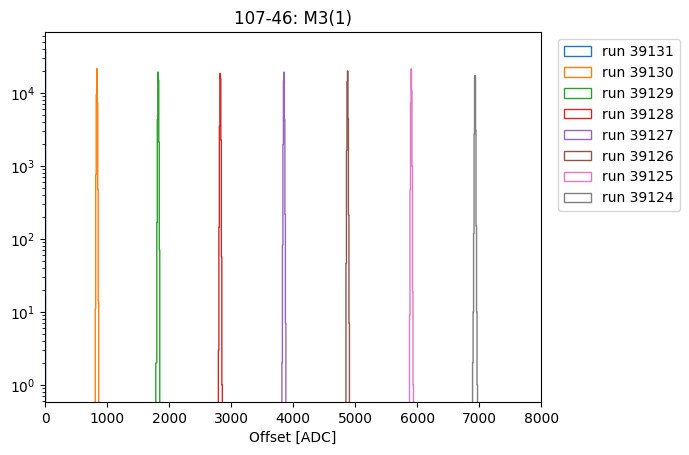

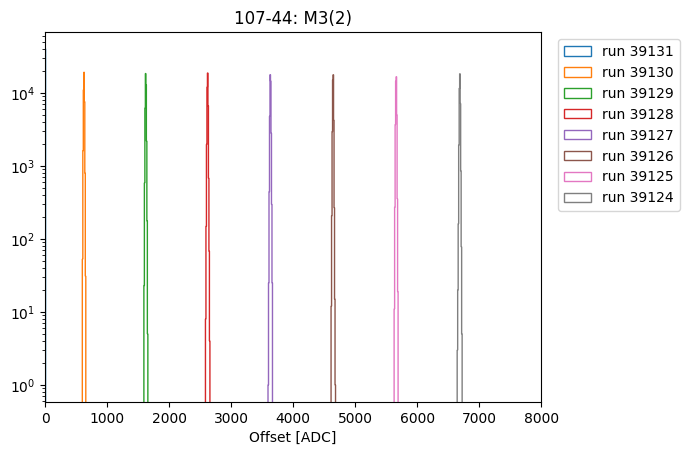

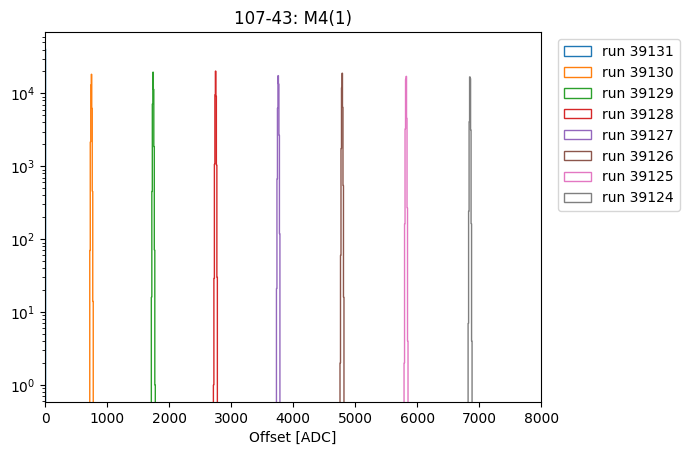

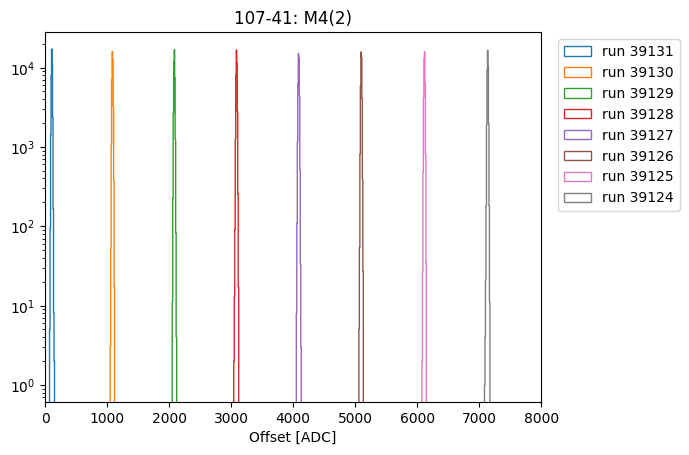

In [75]:
import matplotlib.pyplot as plt
_ = dict_module_to_uniqch.pop(None, None)
# for ch, runcounts in histograms_ch.items():

for module, uch in dict(sorted(dict_module_to_uniqch.items())).items():
    if uch.endpoint !=  endpoint: continue
    if uch.channel not in histograms_ch:
        continue
    #if module == "M5(1)" or module == "M5(2)" or module == "M6(1)" or module == "M6(2)" or module == "M7(1)" or module == "M7(2)" or module == "M8(1)" or module == "M8(2)": 
    #if True or module == "M6(1)" or module == "M6(2)" or module == "M7(1)" or module == "M7(2)": 
    if module == "M5(1)": break
    ch = uch.channel
    runcounts = histograms_ch[uch.channel]
    plt.figure()
    for run, counts in runcounts.items():
        bins_center = 0.5*(bins[1:] + bins[:-1])
        #mean = np.average(bins_center, weights=counts)
        #std_hist = np.average((bins_center - mean)**2, weights=counts)
        #print(f"{mean:.2f}",f"{std_hist:.2f}")
        plt.hist(bins[:-1], bins, weights=counts, histtype="step", label= f"run {run}")
        #plt.hist(bins[:-1], bins, weights=counts, histtype="step", label= f"run {run} - Mean: {mean:.0f}; RMS: {std_hist:.0f}")
    plt.title(f"{endpoint}-{ch}: {module}")
    plt.xlim(bins[0], bins[-1])
    plt.legend(bbox_to_anchor=(1.02,1.0))
    plt.yscale("log")
    plt.xlabel("Offset [ADC]")
    # plt.savefig(f"plots_offset/offsets_{module}.png")
    plt.show()


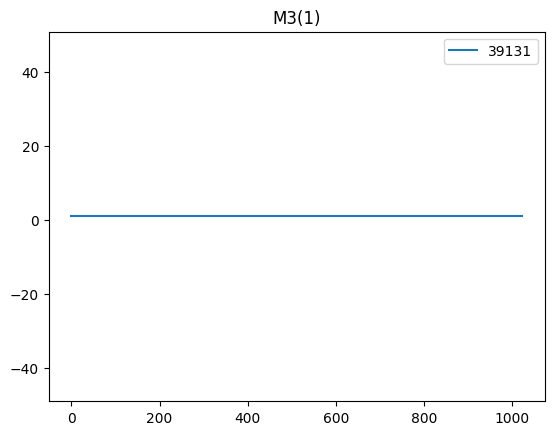

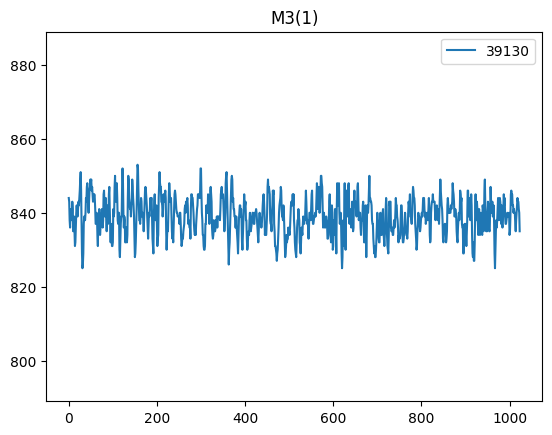

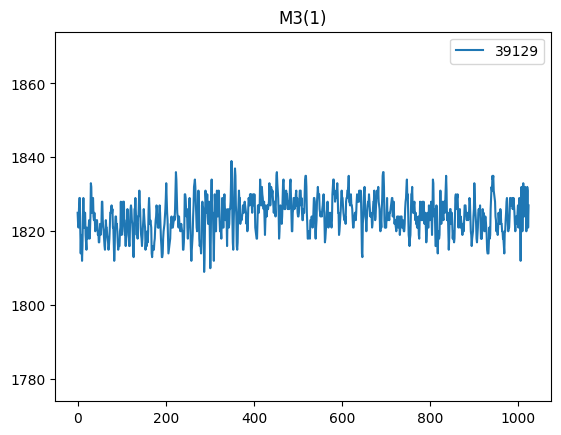

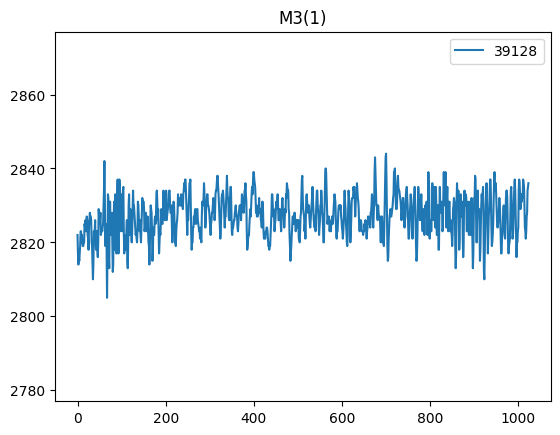

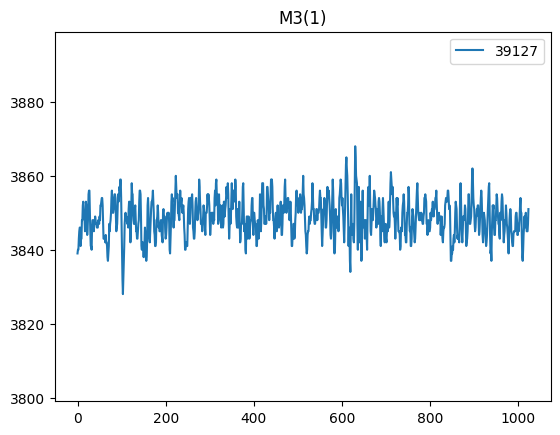

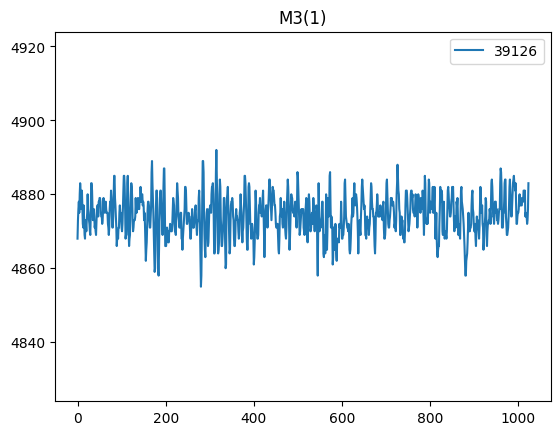

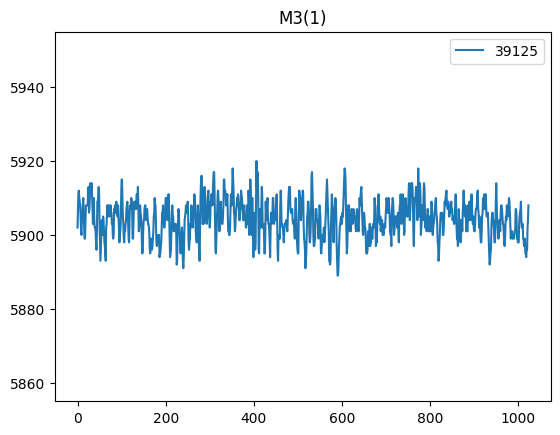

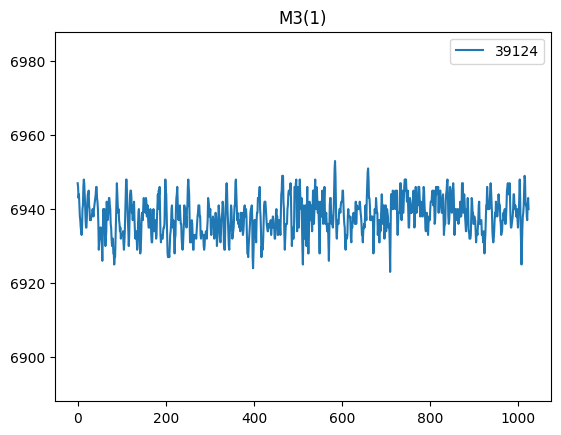

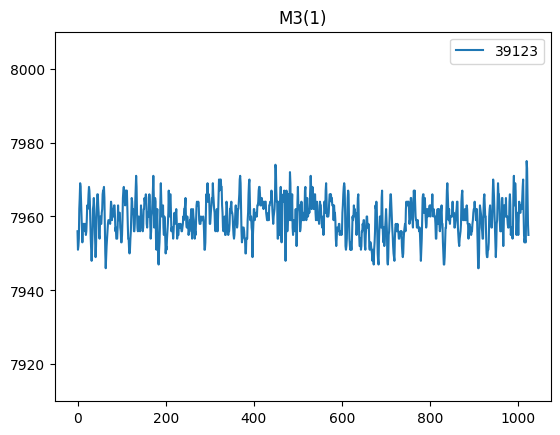

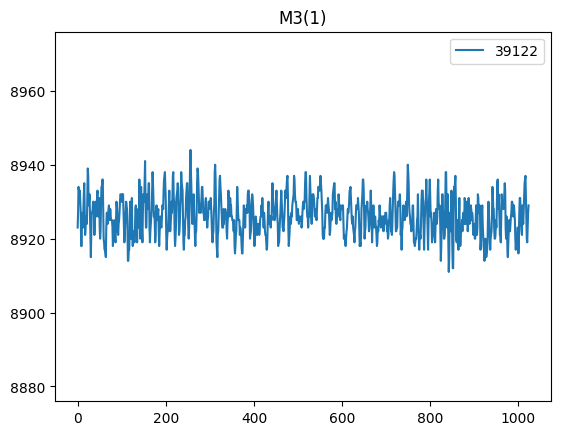

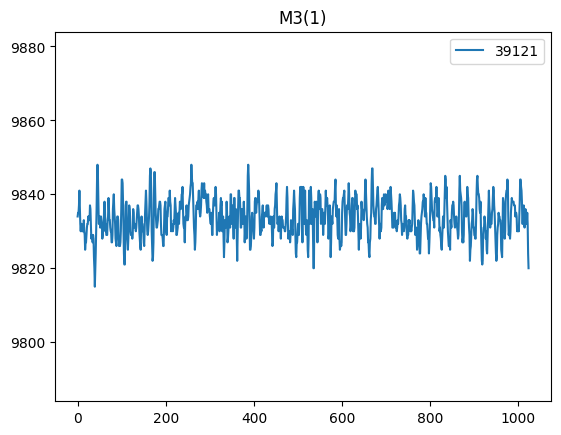

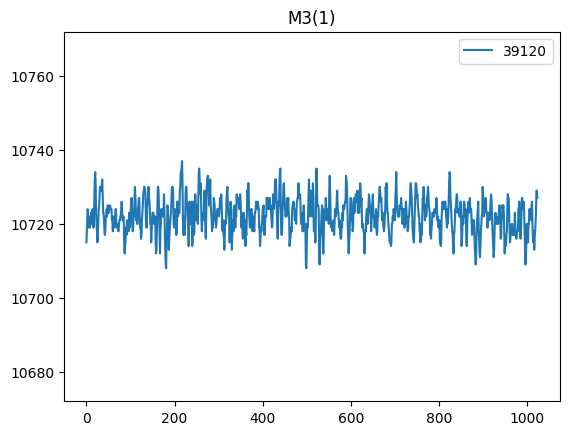

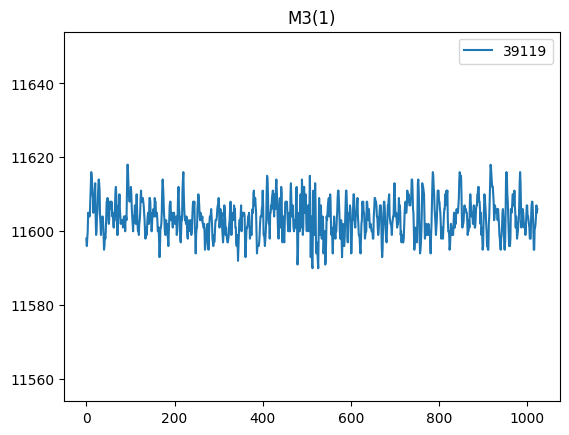

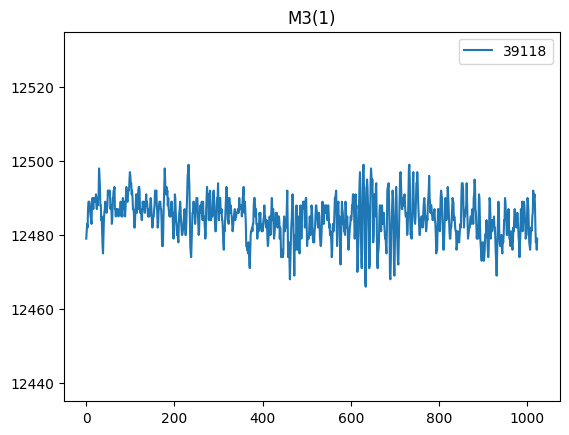

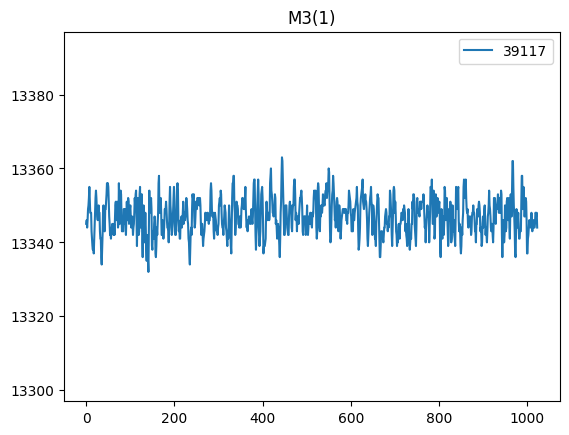

In [71]:

it=0
#it+=1
uch = dict_module_to_uniqch["M3(1)"]
for run in runlist:
    plt.figure()
    wfch = ChannelWsGrid.clusterize_waveform_set(waveforms[run])

    for it in range(0,1):
        plt.plot(wfch[uch.endpoint][uch.channel].waveforms[it].adcs, label=run)
        adcm = np.median(wfch[uch.endpoint][uch.channel].waveforms[it].adcs)
        plt.ylim(-50+adcm, 50+adcm)
        plt.title(dict_uniqch_to_module[str(uch)])
        plt.legend()